In [2]:
import insightface
import numpy as np
import cv2 
import os
from os import listdir
from os.path import isfile, join
from keras.models import load_model
from insightface.app import FaceAnalysis
from keras.models import Model
from keras.layers import Dense, GlobalMaxPooling2D, Input
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2

In [3]:
app = FaceAnalysis()
app.prepare(ctx_id=0)

if app.models:
  detector = app.models.get('retinaface_r50_v1', None)
  if detector:
    detector.nms = 0.4

C:\Users\dttan\AppData\Roaming\Python\Python312\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dttan/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dttan/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dttan/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dttan/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\dttan/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

In [4]:
base_model = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
  layer.trainable = False
num_classes = 5

x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
# print(model.summary())


In [5]:
train_dir = "D:/DangTranTanLuc/Data/Train"
val_dir = "D:/DangTranTanLuc/Data/Validate"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest'

)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical")
validation_generator = train_datagen.flow_from_directory(
    val_dir  ,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical")
label_map = train_generator.class_indices
label_map = {v: k for k, v in label_map.items()}

print("Label Map:", label_map)

Found 100 images belonging to 5 classes.
Found 25 images belonging to 5 classes.
Label Map: {0: 'Dang Tran Tan Luc', 1: 'Nguyen Thi Ngoc Diem', 2: 'Phung Khanh Duy', 3: 'Vo Nguyen Thanh Dieu', 4: 'Vo Thi Cam Tu'}


In [14]:
checkpoint = ModelCheckpoint("model.keras",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 6,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks = callbacks,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
)


Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8769 - loss: 0.4511
Epoch 1: val_loss improved from inf to 2.73636, saving model to model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 5s/step - accuracy: 0.8675 - loss: 0.5063 - val_accuracy: 0.4800 - val_loss: 2.7364
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6306 - loss: 1.4109
Epoch 3: val_loss improved from 2.73636 to 1.00404, saving model to model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.6485 - loss: 1.3261 - val_accuracy: 0.7200 - val_loss: 1.0040
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8389 - loss: 0.8153
Epoch 5: val_loss improved from 1.00404 to 0.83926, saving model to model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.8451 - loss: 0.7732 - val_accuracy: 0.7600 - val_loss: 0.8393


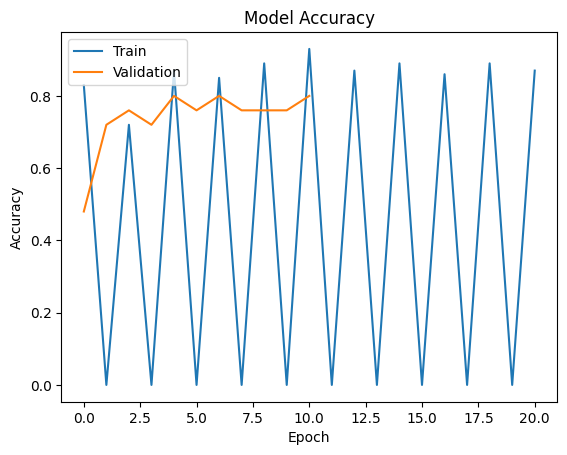

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [16]:
classifier = load_model("D:/DangTranTanLuc/Python/ProjectPy/FaceRecognitionSystem/model.keras")


def draw_test(name, pred, im):
    face = label_map[pred[0]]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, face, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,0,255), 1)
    cv2.imshow("Prediction", expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + path_class)
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)

for i in range(0,10):
    input_im = getRandomImage("D:/DangTranTanLuc/Data/Validate/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)

    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3)

    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)

    draw_test("Prediction", res, input_original)
    cv2.waitKey(0)

cv2.destroyAllWindows()

Class - Vo Thi Cam Tu
Class - Vo Thi Cam Tu
Class - Dang Tran Tan Luc
Class - Vo Thi Cam Tu
Class - Nguyen Thi Ngoc Diem
Class - Vo Thi Cam Tu
Class - Nguyen Thi Ngoc Diem
Class - Vo Thi Cam Tu
Class - Nguyen Thi Ngoc Diem
Class - Vo Nguyen Thanh Dieu


In [17]:
classifier = load_model("D:/DangTranTanLuc/Python/ProjectPy/FaceRecognitionSystem/model.keras")
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [19]:
import cv2
import numpy as np
from PIL import Image

label_map = {0: 'Dang Tran Tan Luc', 1: 'Nguyen Thi Ngoc Diem', 2: 'Phung Khanh Duy', 3: 'Vo Nguyen Thanh Dieu', 4: 'Vo Thi Cam Tu'}


def face_extractor(img):
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    if len(faces) == 0: 
        return None

    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)
        cropped_face = img[y:y + h, x:x + w]
        return cropped_face 

    return None

video_capture = cv2.VideoCapture(0)

if not video_capture.isOpened():
    print("Error: Cannot access the webcam.")
    exit()

while True:
    ret, frame = video_capture.read() 
    if not ret:
        print("Failed to capture frame. Exiting...")
        break

    face = face_extractor(frame)
    if face is not None:
        try:
            face = cv2.resize(face, (224, 224))
            im = Image.fromarray(face, 'RGB')
            img_array = np.array(im)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            pred = classifier.predict(img_array)
            predicted_class = np.argmax(pred, axis=1)
            name = label_map[predicted_class[0]]

            cv2.putText(frame, name, (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)
        except Exception as e:
            print(f"Error during face processing: {e}")
    else:
        cv2.putText(frame, "No face detected", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 2)

    if frame is not None and frame.size > 0:
        cv2.imshow('Video', frame)
    else:
        print("Empty frame detected. Skipping...")

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0